In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
# from tensorflow.keras.layers.experimental import preprocessing 


In [3]:
# target_shape = (128,128)
target_shape = (None,None)

## Model definition

In [4]:
## upsample from pix2pix tf example
# https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    """Upsamples an input.
    Conv2DTranspose => Batchnorm => Dropout => Relu
    Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
    Returns:
    Upsample Sequential Model
    """

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.ReLU())

    return result

In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=target_shape + (3,), include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [6]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [8]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=target_shape + (3,))

    # Downsampling through the model
    skips = down_stack(inputs)
    print([a.shape for a in skips])

    x = skips[-1]
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Get dataset 

In [193]:
def resize_and_pad_image(image, mask, w=600, h=600, stride=32.0):  
    
    # resize image to a size divisible by stride (for unet conv and deconv match)
    
    image_shape = tf.cast(tf.constant([w,h]), dtype=tf.float32) 
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    
    image_resize =  tf.image.resize(image, padded_image_shape, method='bilinear')
    mask_resize = tf.image.resize(mask, padded_image_shape, method='area')
    mask_resize = tf.where(mask_resize<0.08, 0, 1)

    
    tf.debugging.assert_equal(tf.shape(image_resize)[:2], tf.shape(mask_resize)[:2], f'image and mask shape different')
    tf.debugging.assert_equal(tf.shape(image_resize)[:2], padded_image_shape, 'resized image not equal to padded image shape')
    
    return (image_resize,mask_resize) #, image_shape, ratio


def preprocess_images(input_image, input_mask):
    image_string = tf.io.read_file(input_image)
    image = tf.image.decode_png(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)


    mask_string = tf.io.read_file(input_mask)
    mask = tf.image.decode_png(mask_string, channels=1)
    mask = tf.cast(mask/255, tf.int32)
    
    image, mask = resize_and_pad_image(image, mask)
    
    tf.debugging.assert_equal(tf.shape(image)[:2], tf.shape(mask)[:2], f'image and mask shape different')
    
    
    # image, mask = resize_and_pad_image(image, mask)
    
    return image, mask

def augument_images(input_image, input_mask):
    rnd = np.random.rand()
    if(rnd <0.5):
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
       
    for i in range(3):
        rnd = np.random.rand()
        if(rnd <0.4):
            input_image = tf.image.rot90(input_image)
            input_mask = tf.image.rot90(input_mask)
    
        
    return input_image, input_mask
    

In [194]:
# base_dir = './data/'
base_dir = '/archive/floorplan/data-new-iteration/'

input_dir =base_dir+ "ground_truth"
target_dir = base_dir+"masks"
img_size = (None, None)
num_classes = 2
batch_size = 1

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 215
/archive/floorplan/data-new-iteration/ground_truth/Anhelito_1.png | /archive/floorplan/data-new-iteration/masks/Anhelito_1.png
/archive/floorplan/data-new-iteration/ground_truth/Anhelito_10.png | /archive/floorplan/data-new-iteration/masks/Anhelito_10.png
/archive/floorplan/data-new-iteration/ground_truth/Anhelito_11.png | /archive/floorplan/data-new-iteration/masks/Anhelito_11.png
/archive/floorplan/data-new-iteration/ground_truth/Anhelito_12.png | /archive/floorplan/data-new-iteration/masks/Anhelito_12.png
/archive/floorplan/data-new-iteration/ground_truth/Anhelito_13.png | /archive/floorplan/data-new-iteration/masks/Anhelito_13.png
/archive/floorplan/data-new-iteration/ground_truth/Anhelito_14.png | /archive/floorplan/data-new-iteration/masks/Anhelito_14.png
/archive/floorplan/data-new-iteration/ground_truth/Anhelito_15.png | /archive/floorplan/data-new-iteration/masks/Anhelito_15.png
/archive/floorplan/data-new-iteration/ground_truth/Anhelito_16.png | /archiv

In [177]:
mapIndexPosition = list(zip(input_img_paths, target_img_paths))
random.shuffle(mapIndexPosition)

shuffled_input_path = [x[0] for x in mapIndexPosition]
shuffled_target_path = [x[1] for x in mapIndexPosition]

# shuffled_input_path, shuffled_target_path = zip(*mapIndexPosition)

for input_path, target_path in zip(shuffled_input_path[:10], shuffled_target_path[:10]):
    print(input_path, "|", target_path)

/archive/floorplan/data-new-iteration/ground_truth/Anhelito_62.png | /archive/floorplan/data-new-iteration/masks/Anhelito_62.png
/archive/floorplan/data-new-iteration/ground_truth/DanutZzy_33.png | /archive/floorplan/data-new-iteration/masks/DanutZzy_33.png
/archive/floorplan/data-new-iteration/ground_truth/Grosulik_6.png | /archive/floorplan/data-new-iteration/masks/Grosulik_6.png
/archive/floorplan/data-new-iteration/ground_truth/Anhelito_52.png | /archive/floorplan/data-new-iteration/masks/Anhelito_52.png
/archive/floorplan/data-new-iteration/ground_truth/DanutZzy_46.png | /archive/floorplan/data-new-iteration/masks/DanutZzy_46.png
/archive/floorplan/data-new-iteration/ground_truth/DanutZzy_38.png | /archive/floorplan/data-new-iteration/masks/DanutZzy_38.png
/archive/floorplan/data-new-iteration/ground_truth/DanutZzy_3.png | /archive/floorplan/data-new-iteration/masks/DanutZzy_3.png
/archive/floorplan/data-new-iteration/ground_truth/DanutZzy_58.png | /archive/floorplan/data-new-iter

In [178]:
input_img_dataset = tf.data.Dataset.from_tensor_slices(shuffled_input_path)
target_img_dataset = tf.data.Dataset.from_tensor_slices(shuffled_target_path)

dataset = tf.data.Dataset.zip((input_img_dataset, target_img_dataset))
dataset = dataset.map(preprocess_images)
dataset = dataset.map(augument_images)

# Let's now split our dataset in train and validation.
image_count = len(input_img_paths)

train_dataset = dataset.take(round(image_count * 0.6))
val_dataset = dataset.skip(round(image_count * 0.6))
test_dataset = val_dataset.batch(batch_size, drop_remainder=False)

train_dataset = train_dataset.batch(batch_size, drop_remainder=False)
# train_dataset = train_dataset.padded_batch(batch_size, drop_remainder=True)

train_dataset = train_dataset.shuffle(buffer_size=1024)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(batch_size, drop_remainder=True)
# val_dataset = val_dataset.padded_batch(batch_size, drop_remainder=True)

val_dataset = val_dataset.shuffle(buffer_size=1024)
val_dataset = val_dataset.prefetch(8)


In [179]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [180]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [181]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [182]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image[0], sample_mask[0],
                create_mask(model.predict(sample_image))])

In [183]:
def add_sample_weights(image, label):
    # The weights for each class, with the constraint that:
    #     sum(class_weights) == 1.0
#     class_weights = tf.constant([2.0, 2.0, 1.0])
    class_weights = tf.constant([0.5, 9.5])
    
    class_weights = class_weights/tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label at each pixel as an 
    # index into the `class weights` .
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

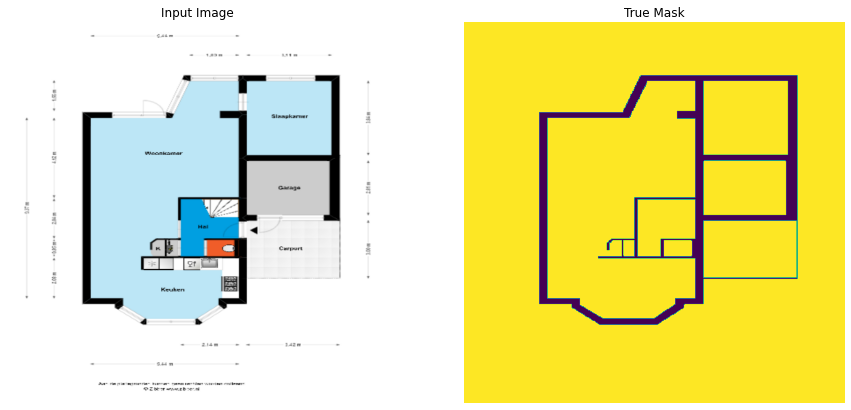

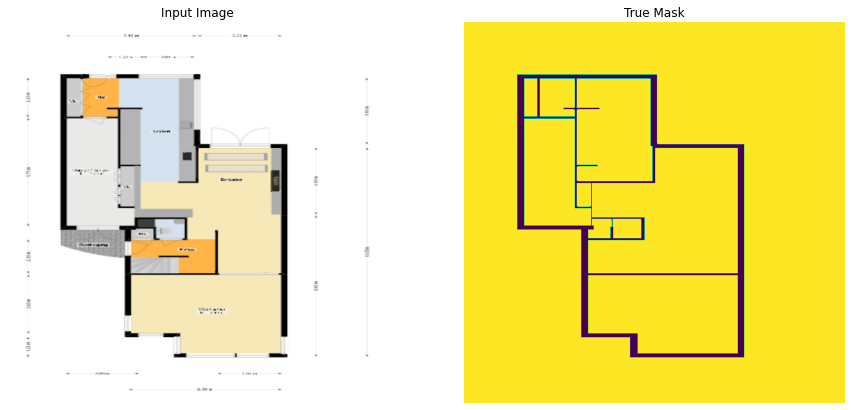

In [192]:
from IPython.display import clear_output
for images, masks in train_dataset.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [49]:
OUTPUT_CLASSES = 2
EPOCHS = 20
# VAL_SUBSPLITS = 5
# VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
model = unet_model(OUTPUT_CLASSES)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

[TensorShape([None, None, None, 96]), TensorShape([None, None, None, 144]), TensorShape([None, None, None, 192]), TensorShape([None, None, None, 576]), TensorShape([None, None, None, 320])]


In [50]:
model.fit(train_dataset.map(add_sample_weights), epochs=40, validation_data=val_dataset)

Epoch 1/40
 36/129 [=======>......................] - ETA: 8s - loss: 0.1152 - accuracy: 0.8998

KeyboardInterrupt: 

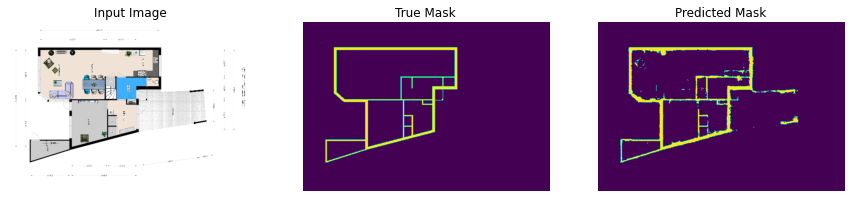

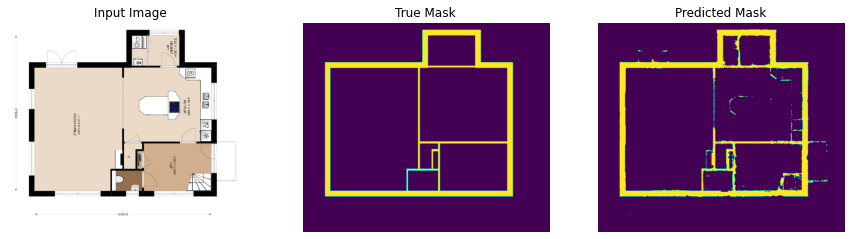

In [477]:
show_predictions(val_dataset,2)